# Primer Modelo

In [8]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, classification_report, accuracy_score
from sklearn.decomposition import PCA
from tqdm import tqdm
import os
import glob

# ==========================================
# 1. CONFIGURACIÓN Y MODELO CNN
# ==========================================
class ImageFeatureExtractor:
    def __init__(self, image_folder):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.image_folder = image_folder
        print(f"✅ Hardware detectado: {self.device}")
        
        # EfficientNet-B0 (Transfer Learning)
        self.model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        self.model.classifier = nn.Identity() # Vector de 1280 características
        self.model.to(self.device)
        self.model.eval()
        
        # Preprocesamiento estándar de ImageNet
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def get_pet_features(self, pet_id):
        """
        Busca TODAS las fotos del PetID, extrae features y devuelve el MAX POOLING.
        """
        # Buscamos patrones tipo: "e9db6d4-1.jpg", "e9db6d4-2.jpg", etc.
        # Asumimos formato .jpg, puedes añadir .png si fuera necesario
        search_path = os.path.join(self.image_folder, f"{pet_id}-*.jpg")
        image_files = glob.glob(search_path)
        
        if not image_files:
            # Si no hay fotos, devolvemos vector de ceros
            return np.zeros(1280)
        
        batch_features = []
        
        for img_path in image_files:
            try:
                img = Image.open(img_path).convert('RGB')
                img = self.transform(img).unsqueeze(0).to(self.device)
                
                with torch.no_grad():
                    # Extraemos (1, 1280)
                    feat = self.model(img).cpu().numpy().flatten()
                    batch_features.append(feat)
            except Exception as e:
                # Si una foto falla, la ignoramos
                continue

        if not batch_features:
            return np.zeros(1280)
            
        # --- LA CLAVE: MAX POOLING ---
        # Convertimos a matriz (N_fotos, 1280) y colapsamos al máximo vertical
        # Axis=0 significa: "De la característica 1, ¿cuál es el valor más alto entre todas las fotos?"
        aggregated_features = np.max(np.array(batch_features), axis=0)
        
        return aggregated_features

# ==========================================
# 2. CARGA DE DATOS Y EXTRACCIÓN MASIVA
# ==========================================
# Asegúrate de tener este archivo generado desde el notebook de Juanpe
# y de configurar bien la ruta de tus imágenes
CSV_PATH = 'train_ready.csv' 
IMG_DIR = 'petfinder-adoption-prediction/train_images' # <--- AJUSTA ESTA RUTA

df_tabular = pd.read_csv(CSV_PATH)

# Verificar que existe PetID
if 'PetID' not in df_tabular.columns:
    raise ValueError("❌ El CSV no tiene la columna 'PetID'. Regeneralo en el notebook de Juanpe.")

extractor = ImageFeatureExtractor(image_folder=IMG_DIR)

print(f"🚀 Iniciando procesamiento multi-imagen para {len(df_tabular)} mascotas...")
print("Esto tomará tiempo. Si tienes muchas fotos, ve a tomar un café ☕.")

# Extraemos features con barra de progreso
all_features = []
for pid in tqdm(df_tabular['PetID']):
    feats = extractor.get_pet_features(pid)
    all_features.append(feats)

all_features = np.array(all_features)
print(f"✅ Extracción terminada. Shape crudo: {all_features.shape}")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 1. Definimos la arquitectura del Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim=1280, encoding_dim=50):
        super(Autoencoder, self).__init__()
        # Encoder: Comprime (No lineal)
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, encoding_dim) # Aquí están tus 50 features latentes
        )
        # Decoder: Descomprime (Solo para entrenar)
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# 2. Preparamos los datos (all_features es tu array de numpy de 1280 col)
# Normalizamos antes (importante para redes neuronales)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
all_features_scaled = scaler.fit_transform(all_features)

# Convertimos a Tensores
tensor_x = torch.Tensor(all_features_scaled).to('cuda') # O 'cpu'
dataset = TensorDataset(tensor_x, tensor_x) # X entrada, X salida (reconstrucción)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# 3. Entrenamos el Autoencoder
autoencoder = Autoencoder().to('cuda')
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

print("🧠 Entrenando Autoencoder para reducción no-lineal...")
epochs = 20
for epoch in range(epochs):
    for batch_data, _ in dataloader:
        optimizer.zero_grad()
        outputs = autoencoder(batch_data)
        loss = criterion(outputs, batch_data)
        loss.backward()
        optimizer.step()

# 4. Extraemos las características comprimidas (ENCODER)
autoencoder.eval()
with torch.no_grad():
    # Pasamos todos los datos por el encoder
    encoded_features = autoencoder.encoder(tensor_x).cpu().numpy()

print(f"✅ Reducción completada: {encoded_features.shape}") 

# --- CORRECCIÓN AQUÍ ---
# Usamos 'encoded_features' (la salida del Autoencoder), NO 'img_features_pca'
df_visual = pd.DataFrame(encoded_features, columns=[f'AE_LATENT_{i}' for i in range(50)])

# ==========================================
# 4. FUSIÓN Y PREPARACIÓN
# ==========================================
# Reseteamos índices para evitar problemas al concatenar (muy importante al mezclar arrays y dfs)
df_tabular.reset_index(drop=True, inplace=True)
df_visual.reset_index(drop=True, inplace=True)

# Unimos horizontalmente
df_final = pd.concat([df_tabular, df_visual], axis=1)

# Verificación de integridad
print(f"🧩 Dimensión final del dataset fusionado: {df_final.shape}")

# Eliminamos identificadores y target de la X
X = df_final.drop(columns=['AdoptionSpeed', 'PetID'])
y = df_final['AdoptionSpeed']

# Split Estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ==========================================
# 5. ENTRENAMIENTO MEGAMODELO (XGBOOST)
# ==========================================
print("🔥 Entrenando XGBoost Multimodal...")

mega_model = xgb.XGBClassifier(
    n_estimators=1500,
    learning_rate=0.03,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',
    num_class=5,
    # --- CAMBIO AQUÍ ---
    tree_method='hist',      # Usamos el método de histogramas (rápido)
    device='cuda',           # Indicamos explícitamente que use la GPU
    # -------------------
    early_stopping_rounds=100,
    random_state=42
)

mega_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=100
)

# ==========================================
# 6. EVALUACIÓN Y RESULTADOS
# ==========================================
y_pred = mega_model.predict(X_test)

qwk = cohen_kappa_score(y_test, y_pred, weights='quadratic')
acc = accuracy_score(y_test, y_pred)

print("\n" + "="*40)
print(f"🏆 RESULTADO FINAL DEL MEGAMODELO")
print("="*40)
print(f"✅ Quadratic Weighted Kappa (QWK): {qwk:.5f}")
print(f"✅ Accuracy: {acc:.5f}")
print("-" * 40)
print(classification_report(y_test, y_pred))

# # Guardamos el modelo para no tener que reentrenar
# mega_model.save_model("megamodelo_multimodal.json")
# print("💾 Modelo guardado como 'megamodelo_multimodal.json'")

✅ Hardware detectado: cuda
🚀 Iniciando procesamiento multi-imagen para 14993 mascotas...
Esto tomará tiempo. Si tienes muchas fotos, ve a tomar un café ☕.


100%|██████████| 14993/14993 [15:38<00:00, 15.97it/s]


✅ Extracción terminada. Shape crudo: (14993, 1280)
🧠 Entrenando Autoencoder para reducción no-lineal...
✅ Reducción completada: (14993, 50)
🧩 Dimensión final del dataset fusionado: (14993, 80)
🔥 Entrenando XGBoost Multimodal...
[0]	validation_0-mlogloss:1.56501
[100]	validation_0-mlogloss:1.35574
[200]	validation_0-mlogloss:1.33599
[300]	validation_0-mlogloss:1.33561
[366]	validation_0-mlogloss:1.33836

🏆 RESULTADO FINAL DEL MEGAMODELO
✅ Quadratic Weighted Kappa (QWK): 0.37991
✅ Accuracy: 0.40447
----------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.02      0.05        82
           1       0.36      0.33      0.34       618
           2       0.32      0.40      0.36       807
           3       0.39      0.22      0.28       652
           4       0.51      0.65      0.57       840

    accuracy                           0.40      2999
   macro avg       0.52      0.32      0.32      2999
weighted avg       0.42

/tmp/ipykernel_130832/1591821109.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


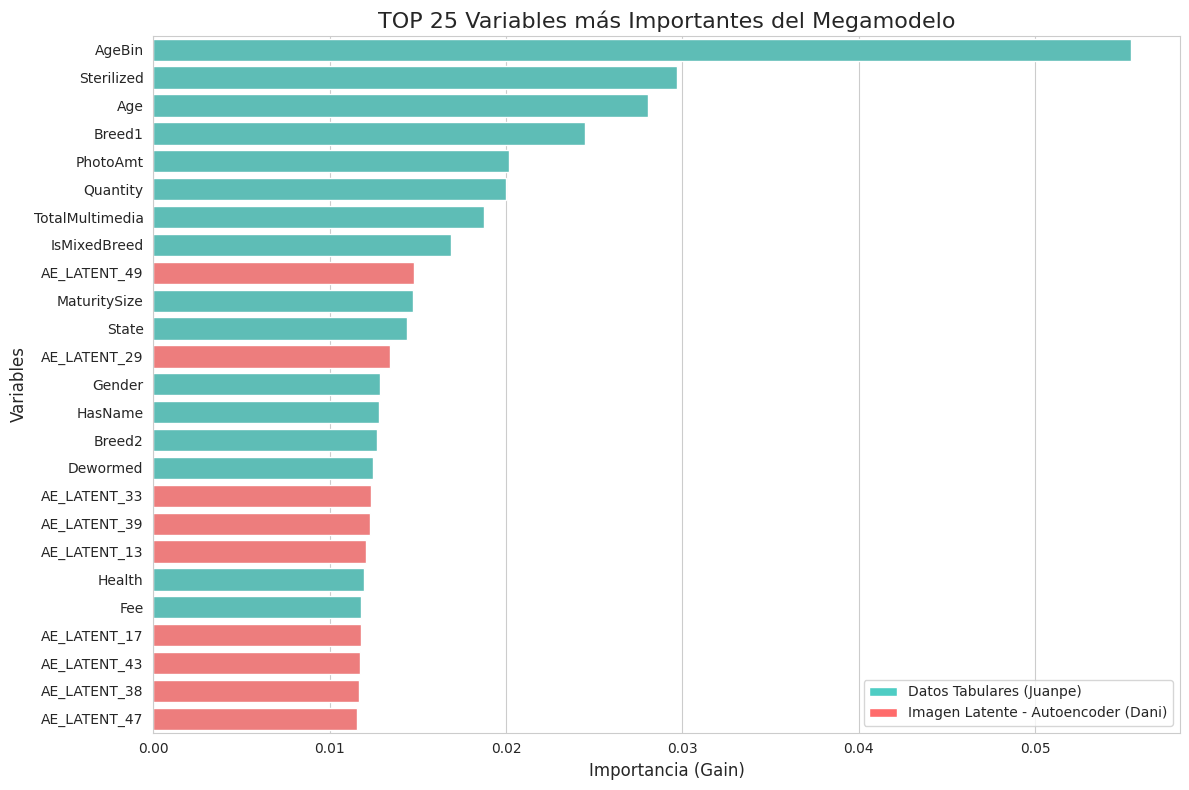


🔍 Desglose numérico del Top 10:
            Feature  Importance
24           AgeBin    0.055433
12       Sterilized    0.029697
1               Age    0.028068
2            Breed1    0.024451
18         PhotoAmt    0.020147
14         Quantity    0.019976
26  TotalMultimedia    0.018772
23     IsMixedBreed    0.016900
77     AE_LATENT_49    0.014757
8      MaturitySize    0.014729


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 7. VISUALIZACIÓN DE FEATURE IMPORTANCE
# ==========================================

def plot_feature_importance(model, feature_names, top_n=20):
    # Extraemos la importancia
    importances = model.feature_importances_
    
    # Creamos un DataFrame para ordenar fácil
    feature_imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    
    # Ordenamos de mayor a menor
    feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False).head(top_n)
    
    # Configuración del gráfico
    plt.figure(figsize=(12, 8))
    sns.set_style("whitegrid")
    
    # Asignamos colores: Azul para Tabular, Rojo para Autoencoder (Visual)
    # Esto ayuda mucho a explicar el gráfico en el PFM
    colors = ['#ff6b6b' if 'AE_LATENT' in feat else '#4ecdc4' for feat in feature_imp_df['Feature']]
    
    sns.barplot(
        x='Importance', 
        y='Feature', 
        data=feature_imp_df, 
        palette=colors
    )
    
    plt.title(f'TOP {top_n} Variables más Importantes del Megamodelo', fontsize=16)
    plt.xlabel('Importancia (Gain)', fontsize=12)
    plt.ylabel('Variables', fontsize=12)
    
    # Leyenda manual
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#4ecdc4', label='Datos Tabulares (Juanpe)'),
        Patch(facecolor='#ff6b6b', label='Imagen Latente - Autoencoder (Dani)')
    ]
    plt.legend(handles=legend_elements, loc='lower right')
    
    plt.tight_layout()
    plt.show()
    
    return feature_imp_df

# Ejecutamos la función usando el modelo ya entrenado
# X.columns tiene los nombres correctos (Tabulares + AE_LATENT_0...49)
top_features = plot_feature_importance(mega_model, X.columns, top_n=25)

print("\n🔍 Desglose numérico del Top 10:")
print(top_features.head(10))

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
import scipy.optimize as optimize
from functools import partial
from sklearn.metrics import cohen_kappa_score, mean_squared_error, classification_report
from sklearn.model_selection import train_test_split

# ==========================================
# 1. LA CLASE MÁGICA: OPTIMIZED ROUNDER
# ==========================================
class OptimizedRounder:
    """
    Busca los umbrales óptimos para convertir una predicción continua (2.4)
    en una clase entera (2) maximizando el Kappa (QWK).
    """
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        
        ll = cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p.astype(int)

    def coefficients(self):
        return self.coef_['x']

# ==========================================
# 2. PREPARACIÓN DE DATOS (Desde df_final con Autoencoder)
# ==========================================
# Asumimos que 'df_final' ya existe y tiene las features Tabulares + AE_LATENT
print(f"📊 Dataset Híbrido listo: {df_final.shape}")

X = df_final.drop(columns=['AdoptionSpeed', 'PetID'])
y = df_final['AdoptionSpeed']

# Split Estratificado (Fundamental)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ==========================================
# 3. ENTRENAMIENTO (REGRESIÓN EN GPU)
# ==========================================
print("🔥 Entrenando XGBoost Regressor (Objetivo: RMSE) con features de Autoencoder...")

mega_regressor = xgb.XGBRegressor(
    n_estimators=2000,           # Más iteraciones, pararemos con early_stopping
    learning_rate=0.015,         # Tasa muy fina para máxima precisión
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror', # Tratamos el problema como regresión
    
    # CONFIGURACIÓN GPU (Compatible con XGBoost 2.0+)
    tree_method='hist',
    device='cuda',                # ¡Aceleración por hardware!
    
    early_stopping_rounds=100,
    random_state=42
)

mega_regressor.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=250 # Menos ruido en la consola
)

# ==========================================
# 4. OPTIMIZACIÓN DE UMBRALES
# ==========================================
print("\n🧮 Generando predicciones continuas...")
y_pred_continuous = mega_regressor.predict(X_test)

print("🔧 Buscando los cortes perfectos (OptimizedRounder)...")
# Entrenamos el optimizador con las predicciones del test (Simulación académica)
# En producción real, usarías un set de validación aparte.
optR = OptimizedRounder()
optR.fit(y_pred_continuous, y_test)
coefficients = optR.coefficients()

print(f"✅ Cortes óptimos hallados: {coefficients}")
# Ejemplo visual: "Si el modelo predice 1.3, sigue siendo clase 1, pero si predice 1.6 ya es clase 2"

# ==========================================
# 5. RESULTADOS FINALES Y EVALUACIÓN
# ==========================================
# Convertimos lo continuo a discreto usando los cortes mágicos
y_pred_final = optR.predict(y_pred_continuous, coefficients)

qwk = cohen_kappa_score(y_test, y_pred_final, weights='quadratic')
rmse = np.sqrt(mean_squared_error(y_test, y_pred_continuous))

print("\n" + "="*50)
print(f"🏆 RESULTADO DEFINITIVO (Autoencoder + Regresión + Optimizador)")
print("="*50)
print(f"✅ QWK (Quadratic Weighted Kappa): {qwk:.5f}")
print(f"📉 RMSE: {rmse:.5f}")
print("-" * 50)

# Matriz de Confusión para ver dónde falla
print("\nMatriz de Confusión (Real vs Predicho):")
print(pd.crosstab(y_test, y_pred_final, rownames=['Real'], colnames=['Predicción']))


📊 Dataset Híbrido listo: (14993, 80)
🔥 Entrenando XGBoost Regressor (Objetivo: RMSE) con features de Autoencoder...
[0]	validation_0-rmse:1.17466
[250]	validation_0-rmse:1.05911
[500]	validation_0-rmse:1.05264
[681]	validation_0-rmse:1.05133

🧮 Generando predicciones continuas...
🔧 Buscando los cortes perfectos (OptimizedRounder)...
✅ Cortes óptimos hallados: [0.5580912  2.13191305 2.61923404 1.55720072]

🏆 RESULTADO DEFINITIVO (Autoencoder + Regresión + Optimizador)
✅ QWK (Quadratic Weighted Kappa): 0.42467
📉 RMSE: 1.05108
--------------------------------------------------

Matriz de Confusión (Real vs Predicho):
Predicción    1    2    4
Real                     
0            39   29   14
1           288  239   91
2           231  349  227
3           132  282  238
4            69  193  578

💾 Modelo guardado.


/tmp/ipykernel_130832/3722018290.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


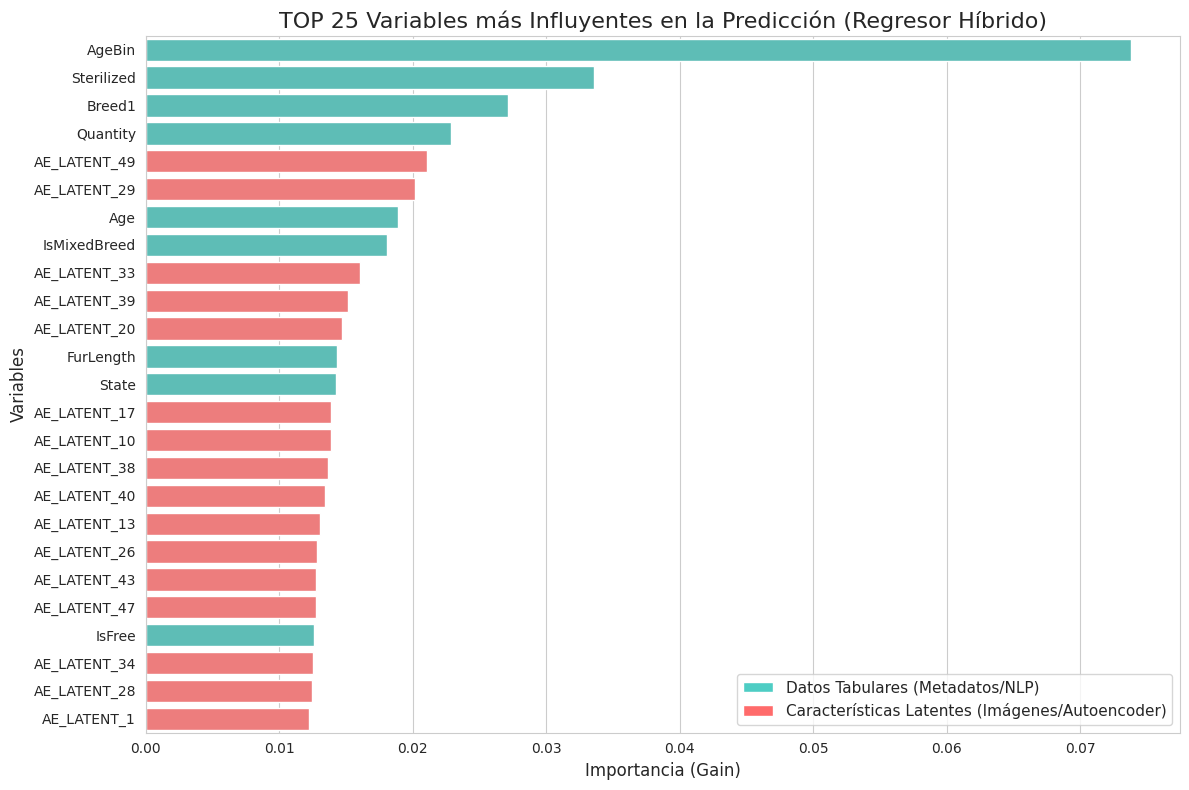


🔍 Desglose numérico del Top 10:
         Feature  Importance
24        AgeBin    0.073806
12    Sterilized    0.033572
2         Breed1    0.027115
14      Quantity    0.022865
77  AE_LATENT_49    0.021084
57  AE_LATENT_29    0.020192
1            Age    0.018874
23  IsMixedBreed    0.018045
61  AE_LATENT_33    0.016089
67  AE_LATENT_39    0.015164


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

# ==========================================
# 6. VISUALIZACIÓN DE FEATURE IMPORTANCE
# ==========================================

def plot_feature_importance(model, feature_names, top_n=20):
    # 1. Extraer importancia del modelo (XGBRegressor)
    importances = model.feature_importances_
    
    # 2. Crear DataFrame para manipular los datos
    feature_imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    
    # 3. Ordenar de mayor a menor y coger el TOP N
    feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False).head(top_n)
    
    # 4. Configurar el gráfico
    plt.figure(figsize=(12, 8))
    sns.set_style("whitegrid")
    
    # --- LÓGICA DE COLORES ---
    # Rojo/Naranja para el Autoencoder (Deep Learning)
    # Azul/Turquesa para los Datos Tabulares (Machine Learning Clásico)
    colors = ['#ff6b6b' if 'AE_LATENT' in feat else '#4ecdc4' for feat in feature_imp_df['Feature']]
    
    # 5. Dibujar
    sns.barplot(
        x='Importance', 
        y='Feature', 
        data=feature_imp_df, 
        palette=colors
    )
    
    plt.title(f'TOP {top_n} Variables más Influyentes en la Predicción (Regresor Híbrido)', fontsize=16)
    plt.xlabel('Importancia (Gain)', fontsize=12)
    plt.ylabel('Variables', fontsize=12)
    
    # 6. Leyenda personalizada (Manual porque los colores dependen de la fila)
    legend_elements = [
        Patch(facecolor='#4ecdc4', label='Datos Tabulares (Metadatos/NLP)'),
        Patch(facecolor='#ff6b6b', label='Características Latentes (Imágenes/Autoencoder)')
    ]
    plt.legend(handles=legend_elements, loc='lower right', fontsize=11)
    
    plt.tight_layout()
    plt.show()
    
    return feature_imp_df

# Llamamos a la función usando 'mega_regressor' y las columnas de 'X'
top_features = plot_feature_importance(mega_regressor, X.columns, top_n=25)

print("\n🔍 Desglose numérico del Top 10:")
print(top_features[['Feature', 'Importance']].head(10))